In [12]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.core.pylabtools import figsize
from sympy import false
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm

import glob

from unicodedata import bidirectional


In [13]:
#function load dataset
def har_dataset(phase):
    x = []
    data_dir = f'HAR_Dataset/{phase}/Inertial Signals/*'
    for file_dir in glob.glob(data_dir):
        x.append(np.loadtxt(file_dir))
    y = np.loadtxt(f'HAR_Dataset/{phase}/y_{phase}.txt')
    #x,y to Tensor
    x = torch.FloatTensor(x).permute(1, 2, 0)
    y = torch.LongTensor(y) - 1
    return x, y


In [14]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

In [15]:
x_train.shape, y_train.shape

(torch.Size([7352, 128, 9]), torch.Size([7352]))

In [16]:
x_test.shape, y_test.shape

(torch.Size([2947, 128, 9]), torch.Size([2947]))

In [17]:
y_train

tensor([4, 4, 4,  ..., 1, 1, 1])

In [18]:
torch.unique(y_train)

tensor([0, 1, 2, 3, 4, 5])

In [19]:
# Tensor Dataset
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

In [20]:
#dataloader
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [33]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 128, 9]) torch.Size([64])


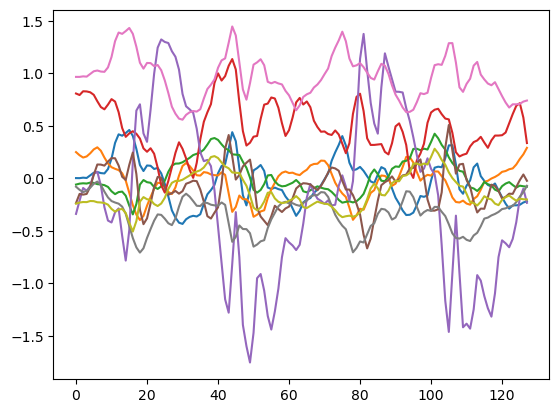

In [34]:
#plot one sample
plt.plot(x[0])
# plt.show()

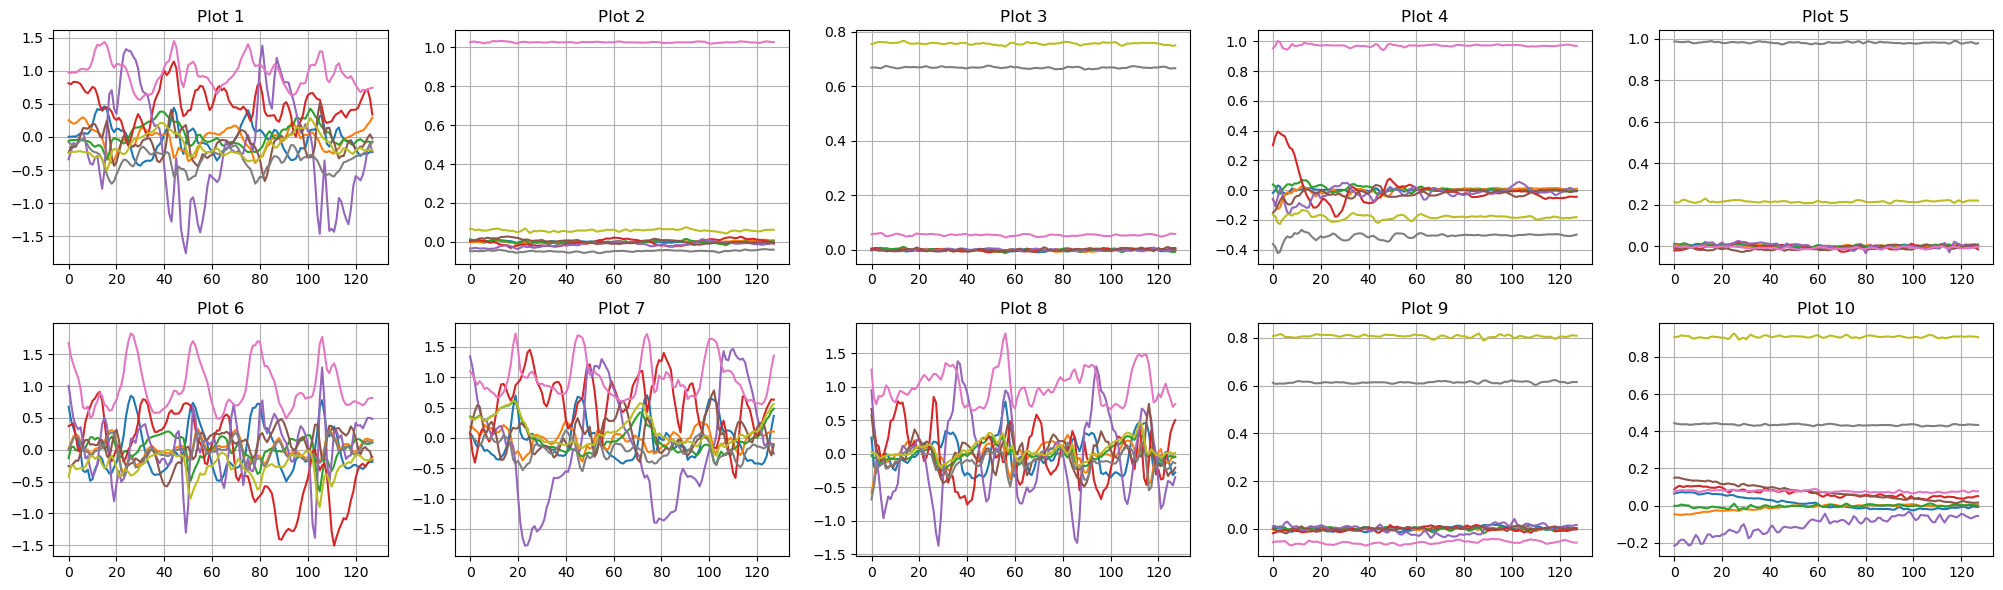

In [51]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
axes = axes.flatten()

for i in range(10):
    axes[i].plot(x[i])
    axes[i].grid(True)
    axes[i].set_title(f'Plot {i + 1}')

plt.tight_layout()
plt.show()


In [58]:
# model
model = nn.RNN(input_size=9,
               hidden_size=32,
               num_layers=1,
               nonlinearity='tanh',
               bias=True,
               batch_first=True,
               dropout=0.,
               bidirectional=False)

In [53]:
model

RNN(9, 32, batch_first=True)

In [54]:
model.all_weights

[[Parameter containing:
  tensor([[-0.0872,  0.1563, -0.1031, -0.0772, -0.1445, -0.1485,  0.0337,  0.1296,
            0.0451],
          [-0.1019,  0.0265, -0.0375, -0.0429, -0.0492,  0.1103, -0.0848, -0.0928,
           -0.0059],
          [-0.1758,  0.0900, -0.1541,  0.0692, -0.0493, -0.0009,  0.0345, -0.0028,
            0.1321],
          [-0.1045, -0.1155, -0.1119,  0.0615, -0.1338,  0.0708,  0.1082, -0.1271,
            0.0091],
          [ 0.0121,  0.1631, -0.1581,  0.0086, -0.1277,  0.1474, -0.1233, -0.0252,
           -0.0146],
          [ 0.0782, -0.0007, -0.0976,  0.0852,  0.1017, -0.1536, -0.0610, -0.1521,
            0.0371],
          [ 0.1737,  0.1192,  0.1070,  0.0927, -0.0560,  0.0462, -0.0850,  0.1571,
            0.0053],
          [ 0.0236, -0.1504, -0.0555,  0.0584, -0.1000, -0.0288,  0.1098, -0.0098,
            0.0897],
          [-0.0785,  0.1016,  0.0644, -0.0414, -0.1455,  0.1427, -0.1441, -0.1259,
           -0.1601],
          [-0.1571, -0.1493, -0.0567, -0

In [55]:
model.bias_hh_l0

Parameter containing:
tensor([-0.1235,  0.1336,  0.0255,  0.0275,  0.0799,  0.0778,  0.0357,  0.0900,
        -0.1622, -0.1115, -0.1317,  0.0850, -0.0385, -0.0754, -0.1237, -0.0967,
         0.1071, -0.1600,  0.0854, -0.0691,  0.1621, -0.1712,  0.0805,  0.0036,
         0.1441, -0.0025, -0.1223, -0.1353,  0.0581,  0.1203,  0.1642, -0.0089],
       requires_grad=True)

In [56]:
model.bias_hh_l0.shape

torch.Size([32])

In [60]:
outputs, hn = model(x)

In [61]:
hn

tensor([[[ 0.1530,  0.0596,  0.1316,  ...,  0.2695, -0.2618, -0.1455],
         [ 0.1875, -0.0328,  0.0521,  ...,  0.3543, -0.3444, -0.0250],
         [ 0.0522, -0.2801,  0.0747,  ...,  0.0072, -0.0340,  0.2164],
         ...,
         [ 0.1053, -0.0553, -0.0756,  ...,  0.3505, -0.3155,  0.1814],
         [-0.0613, -0.1090,  0.0128,  ...,  0.3605, -0.3474,  0.2055],
         [-0.0576, -0.1686,  0.0108,  ..., -0.1540, -0.0344,  0.0351]]],
       grad_fn=<StackBackward0>)

In [62]:
hn.shape

torch.Size([1, 64, 32])

In [63]:
outputs.shape

torch.Size([64, 128, 32])

In [65]:
print(outputs[0, -1])
print(hn[0, 0])

tensor([ 0.1530,  0.0596,  0.1316,  0.4231, -0.4540,  0.2751, -0.0685, -0.1335,
        -0.4657, -0.0093,  0.1250,  0.1069, -0.0836, -0.2818, -0.1182,  0.1208,
         0.2596,  0.2431, -0.0135, -0.0215,  0.3067, -0.1226, -0.3121,  0.2470,
        -0.1388,  0.0897, -0.3440, -0.0298,  0.5021,  0.2695, -0.2618, -0.1455],
       grad_fn=<SelectBackward0>)
tensor([ 0.1530,  0.0596,  0.1316,  0.4231, -0.4540,  0.2751, -0.0685, -0.1335,
        -0.4657, -0.0093,  0.1250,  0.1069, -0.0836, -0.2818, -0.1182,  0.1208,
         0.2596,  0.2431, -0.0135, -0.0215,  0.3067, -0.1226, -0.3121,  0.2470,
        -0.1388,  0.0897, -0.3440, -0.0298,  0.5021,  0.2695, -0.2618, -0.1455],
       grad_fn=<SelectBackward0>)


In [66]:
model(x, torch.zeros(1, 64, 32))

(tensor([[[ 0.1731,  0.0649,  0.1005,  ...,  0.0383, -0.1038, -0.2622],
          [ 0.1344,  0.0748,  0.1685,  ...,  0.1344, -0.2374, -0.3606],
          [ 0.1614,  0.0996,  0.1935,  ...,  0.1586, -0.3040, -0.2707],
          ...,
          [ 0.1259,  0.0871,  0.2118,  ...,  0.2353, -0.2814, -0.2097],
          [ 0.1122,  0.0655,  0.1869,  ...,  0.2361, -0.2902, -0.1693],
          [ 0.1530,  0.0596,  0.1316,  ...,  0.2695, -0.2618, -0.1455]],
 
         [[ 0.1275, -0.0771, -0.0126,  ...,  0.1316, -0.2293, -0.0834],
          [ 0.1343, -0.0686,  0.0427,  ...,  0.2681, -0.2946, -0.0998],
          [ 0.1702, -0.0340,  0.0414,  ...,  0.3261, -0.3473, -0.0550],
          ...,
          [ 0.1878, -0.0326,  0.0542,  ...,  0.3527, -0.3440, -0.0274],
          [ 0.1873, -0.0328,  0.0534,  ...,  0.3537, -0.3444, -0.0258],
          [ 0.1875, -0.0328,  0.0521,  ...,  0.3543, -0.3444, -0.0250]],
 
         [[-0.0363, -0.1919,  0.0169,  ...,  0.0329, -0.0287,  0.2275],
          [-0.0128, -0.2540,

In [75]:
# custom model
class RNN_Custom_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fully_connected_1 = nn.Linear(in_features=4, out_features=32)
        self.batch_norm_1 = nn.BatchNorm1d(num_features=32)
        self.fully_connected_2 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        y = torch.relu(self.batch_norm_1(self.fully_connected_1(x)))
        y = self.fully_connected_2(y)
        y = torch.sigmoid(y)
        return y

In [76]:
model = RNN_Custom_Model()
model

RNN_Custom_Model(
  (fully_connected_1): Linear(in_features=4, out_features=32, bias=True)
  (batch_norm_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected_2): Linear(in_features=32, out_features=1, bias=True)
)

In [78]:
model(torch.randn(3, 4))

tensor([[0.6060],
        [0.5224],
        [0.6485]], grad_fn=<SigmoidBackward0>)

In [84]:
class RNN_Custom_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fully_connected_1 = nn.Linear(in_features=4, out_features=32)
        self.fully_connected_2 = nn.Linear(in_features=32, out_features=64)
        self.fully_connected_3 = nn.Linear(in_features=32, out_features=64)

    def forward(self, x):
        y1 = self.fully_connected_1(x)
        y2 = self.fully_connected_2(y1)
        y3 = self.fully_connected_3(y1)
        y = torch.cat((y2, y3), dim=1)
        return y, y1

In [85]:
model = RNN_Custom_Model()
model

RNN_Custom_Model(
  (fully_connected_1): Linear(in_features=4, out_features=32, bias=True)
  (fully_connected_2): Linear(in_features=32, out_features=64, bias=True)
  (fully_connected_3): Linear(in_features=32, out_features=64, bias=True)
)

In [87]:
a, b = model(torch.randn(3, 4))
a.shape, b.shape

(torch.Size([3, 128]), torch.Size([3, 32]))

In [105]:
# RNN Model
class RNN_Custom_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, num_cls):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          bidirectional=bidirectional)
        # hidden_size = hidden_size *2 id bidirectional else hidden_size
        # self.fully_connected_1 = nn.Linear(hidden_size,num_cls)
        self.fully_connected_1 = nn.LazyLinear(num_cls)

    def forward(self, x):
        outputs, hidden = self.rnn(x)
        y = self.fully_connected_1(outputs[:, -1])
        return y

In [106]:
 model = RNN_Custom_Model(9, 32, 1, False, 6)
model

RNN_Custom_Model(
  (rnn): RNN(9, 32)
  (fully_connected_1): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [104]:
model(x)

tensor([[-1.5735e-01,  9.2987e-02,  1.1376e-01,  3.9319e-02, -8.5761e-02,
         -2.3186e-01],
        [-8.6722e-02,  7.4846e-02,  7.7075e-02,  2.5852e-02,  6.3905e-02,
         -1.9327e-01],
        [ 4.2677e-02,  1.7326e-01,  3.9095e-02,  7.5055e-02,  3.0815e-02,
         -9.2745e-02],
        [-1.1969e-01,  7.7220e-02,  1.9967e-02,  5.5703e-02, -8.8656e-02,
         -2.4308e-01],
        [-7.3096e-02,  1.2013e-01, -8.8411e-03,  8.0448e-02, -2.6697e-02,
         -1.3080e-01],
        [-1.4198e-01,  1.2373e-01,  3.7037e-02,  7.4579e-02, -1.8993e-01,
         -1.7251e-01],
        [-1.3796e-02,  9.2528e-02,  1.6993e-01, -3.8798e-02,  4.3541e-02,
         -1.5250e-01],
        [-1.1657e-01,  5.1678e-02,  1.3460e-01, -2.3360e-02, -1.3565e-02,
         -1.9083e-01],
        [ 3.0306e-02,  1.9472e-01, -6.9520e-03,  1.1380e-01,  1.5637e-02,
         -9.3196e-02],
        [ 1.6201e-02,  2.0644e-01,  2.9540e-03,  7.9820e-02, -3.1200e-02,
         -1.8017e-01],
        [-1.2182e-01,  1.0305e

In [107]:
model(x).shape

torch.Size([64, 6])

In [108]:
model.fully_connected_1.weight.shape

torch.Size([6, 32])

In [109]:
# Set Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [110]:
#utils
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [128]:
#train function
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task='multiclass', num_classes=6).to(device)
    with tqdm(train_loader, unit='batch') as pbar:
        for x_batch, y_batch in pbar:
            if epoch is not None:
                pbar.set_description(f'Epoch {epoch}')
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch).to(device)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train.update(loss.item())
            acc_train(yp, y_batch).to(device)
            pbar.set_postfix(loss=loss_train.avg, accuracy=100. * acc_train.compute().item())
    return model, loss_train.avg, acc_train.compute().item()

In [148]:
# validation fucntion
def evaluate(model, valid_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task='multiclass', num_classes=6).to(device)
        for i, (x_batch, y_batch) in enumerate(valid_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch).to(device)
            loss_valid.update(loss.item())
            acc_valid(yp, y_batch).to(device)
    return loss_valid.avg, acc_valid.compute().item()

In [136]:
# Efficient for set hyperparams
#step 1: check forward path on one batch
model = RNN_Custom_Model(9, 32, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(1.7653, device='cuda:0', grad_fn=<NllLossBackward0>)


In [137]:
#step 2: check backward path on 5 random batch
_, mini_train_dataset = random_split(train_set, (len(train_set) - 500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 6)

In [138]:
model = RNN_Custom_Model(9, 32, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [139]:
num_epochs = 100
for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 84/84 [00:00<00:00, 114.64batch/s, accuracy=97.8, loss=0.117]


In [142]:

# select best Lr
num_epochs = 5
for lr in [0.1, 0.01, 0.001]:
    print(f'Learning rate: {lr}')
    model = RNN_Custom_Model(9, 32, 1, False, 6).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    for epoch in range(num_epochs):
        model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
        print()

Learning rate: 0.1


Epoch 0: 100%|██████████| 115/115 [00:01<00:00, 91.25batch/s, accuracy=38.7, loss=1.56]


Epoch 1: 100%|██████████| 115/115 [00:01<00:00, 98.26batch/s, accuracy=46.8, loss=1.3] 


Epoch 2: 100%|██████████| 115/115 [00:01<00:00, 94.41batch/s, accuracy=50.3, loss=1.22]


Epoch 3: 100%|██████████| 115/115 [00:01<00:00, 98.71batch/s, accuracy=51.9, loss=1.16]


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 99.50batch/s, accuracy=52.9, loss=1.13] 



Learning rate: 0.01


Epoch 0: 100%|██████████| 115/115 [00:01<00:00, 87.42batch/s, accuracy=31.4, loss=1.77]


Epoch 1: 100%|██████████| 115/115 [00:01<00:00, 78.23batch/s, accuracy=39.2, loss=1.72]


Epoch 2: 100%|██████████| 115/115 [00:01<00:00, 80.13batch/s, accuracy=40, loss=1.67]  


Epoch 3: 100%|██████████| 115/115 [00:01<00:00, 80.98batch/s, accuracy=39.6, loss=1.61]


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 79.86batch/s, accuracy=40.1, loss=1.55]



Learning rate: 0.001


Epoch 0: 100%|██████████| 115/115 [00:01<00:00, 79.33batch/s, accuracy=12.2, loss=1.8]


Epoch 1: 100%|██████████| 115/115 [00:01<00:00, 80.43batch/s, accuracy=12, loss=1.8]  


Epoch 2: 100%|██████████| 115/115 [00:01<00:00, 81.57batch/s, accuracy=13.5, loss=1.79]


Epoch 3: 100%|██████████| 115/115 [00:01<00:00, 80.68batch/s, accuracy=15.3, loss=1.79]


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 78.25batch/s, accuracy=18.4, loss=1.78]

In [143]:

#Create small grid based on the "weight_decay" and the "Learning rate"
num_epochs = 5
for lr in [0.08, 0.09, 0.1, 0.15, 0.2]:
    for wd in [1e-4, 1e-5, 0.]:
        model = RNN_Custom_Model(9, 32, 1, False, 6).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
        print(f'Learning rate: {lr}, Weight decay: {wd}')
        for epoch in range(num_epochs):
            model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
        print()

Learning rate: 0.08, Weight decay: 0.0001


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 83.62batch/s, accuracy=51.8, loss=1.16]



Learning rate: 0.08, Weight decay: 1e-05


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 81.01batch/s, accuracy=52.6, loss=1.17]



Learning rate: 0.08, Weight decay: 0.0


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 82.15batch/s, accuracy=52.9, loss=1.16]



Learning rate: 0.09, Weight decay: 0.0001


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 82.44batch/s, accuracy=52, loss=1.15]  



Learning rate: 0.09, Weight decay: 1e-05


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 82.14batch/s, accuracy=51.9, loss=1.15]



Learning rate: 0.09, Weight decay: 0.0


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 80.69batch/s, accuracy=52.8, loss=1.15]



Learning rate: 0.1, Weight decay: 0.0001


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 80.03batch/s, accuracy=52.9, loss=1.12]



Learning rate: 0.1, Weight decay: 1e-05


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 94.29batch/s, accuracy=52.4, loss=1.14]



Learning rate: 0.1, Weight decay: 0.0


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 94.28batch/s, accuracy=53.1, loss=1.12]



Learning rate: 0.15, Weight decay: 0.0001


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 92.99batch/s, accuracy=54, loss=1.07]  



Learning rate: 0.15, Weight decay: 1e-05


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 94.97batch/s, accuracy=54.4, loss=1.08]



Learning rate: 0.15, Weight decay: 0.0


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 85.67batch/s, accuracy=53.8, loss=1.08]



Learning rate: 0.2, Weight decay: 0.0001


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 95.59batch/s, accuracy=55.3, loss=1.05]



Learning rate: 0.2, Weight decay: 1e-05


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 78.91batch/s, accuracy=56.2, loss=1.03]



Learning rate: 0.2, Weight decay: 0.0


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 95.59batch/s, accuracy=55.2, loss=1.04]

In [171]:
# Train Model 20 epoch for full train_loader
model = RNN_Custom_Model(9, 32, 1, False, 6).to(device)

In [170]:
model

RNN_Custom_Model(
  (rnn): RNN(9, 32)
  (fully_connected_1): Linear(in_features=32, out_features=6, bias=True)
)

In [173]:
lr = 0.01
wd = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [174]:
loss_train_history = []
acc_train_history = []

loss_val_history = []
acc_val_history = []

best_loss_val = torch.inf
epoch_counter = 0

In [175]:
num_epochs = 20
for epoch in range(num_epochs):
    #Train
    model,loss_train,acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    #valid
    loss_valid,acc_valid =evaluate(model,test_loader,loss_fn)

    loss_train_history.append(loss_train)
    acc_train_history.append(acc_train)
    loss_val_history.append(loss_valid)
    acc_val_history.append(acc_valid)

    if loss_valid < best_loss_val:
        torch.save(model, f'model.pt')
        best_loss_val = loss_valid
    print(f'Validation: Loss={loss_valid:.2}, Accuracy={acc_valid:.2}')
    print()

    epoch_counter += 1

Epoch 0: 100%|██████████| 115/115 [00:01<00:00, 86.46batch/s, accuracy=46.3, loss=1.27]


Validation: Loss=1.2, Accuracy=0.5



Epoch 1: 100%|██████████| 115/115 [00:01<00:00, 102.89batch/s, accuracy=55.7, loss=1.01]


Validation: Loss=1.2, Accuracy=0.51



Epoch 2: 100%|██████████| 115/115 [00:01<00:00, 99.54batch/s, accuracy=62.1, loss=0.924] 


Validation: Loss=1.2, Accuracy=0.57



Epoch 3: 100%|██████████| 115/115 [00:01<00:00, 99.48batch/s, accuracy=68.5, loss=0.81] 


Validation: Loss=1.0, Accuracy=0.61



Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 94.42batch/s, accuracy=71.2, loss=0.73] 


Validation: Loss=1.0, Accuracy=0.63



Epoch 5: 100%|██████████| 115/115 [00:01<00:00, 98.74batch/s, accuracy=72, loss=0.682]  


Validation: Loss=0.94, Accuracy=0.64



Epoch 6: 100%|██████████| 115/115 [00:01<00:00, 93.24batch/s, accuracy=73.8, loss=0.648]


Validation: Loss=0.9, Accuracy=0.64



Epoch 7: 100%|██████████| 115/115 [00:01<00:00, 94.58batch/s, accuracy=74.3, loss=0.629]


Validation: Loss=0.86, Accuracy=0.66



Epoch 8: 100%|██████████| 115/115 [00:01<00:00, 96.93batch/s, accuracy=75.7, loss=0.609]


Validation: Loss=0.83, Accuracy=0.65



Epoch 9: 100%|██████████| 115/115 [00:01<00:00, 101.46batch/s, accuracy=75.7, loss=0.595]


Validation: Loss=0.84, Accuracy=0.66



Epoch 10: 100%|██████████| 115/115 [00:01<00:00, 100.07batch/s, accuracy=75.5, loss=0.589]


Validation: Loss=0.88, Accuracy=0.66



Epoch 11: 100%|██████████| 115/115 [00:01<00:00, 101.45batch/s, accuracy=75.8, loss=0.586]


Validation: Loss=0.82, Accuracy=0.66



Epoch 12: 100%|██████████| 115/115 [00:01<00:00, 96.86batch/s, accuracy=76.4, loss=0.569]


Validation: Loss=0.84, Accuracy=0.67



Epoch 13: 100%|██████████| 115/115 [00:01<00:00, 100.06batch/s, accuracy=76.4, loss=0.564]


Validation: Loss=0.83, Accuracy=0.66



Epoch 14: 100%|██████████| 115/115 [00:01<00:00, 98.16batch/s, accuracy=76.7, loss=0.559]


Validation: Loss=0.82, Accuracy=0.67



Epoch 15: 100%|██████████| 115/115 [00:01<00:00, 100.07batch/s, accuracy=77.4, loss=0.546]


Validation: Loss=0.83, Accuracy=0.68



Epoch 16: 100%|██████████| 115/115 [00:01<00:00, 98.75batch/s, accuracy=77.2, loss=0.547]


Validation: Loss=0.83, Accuracy=0.67



Epoch 17: 100%|██████████| 115/115 [00:01<00:00, 95.60batch/s, accuracy=77.3, loss=0.543]


Validation: Loss=0.8, Accuracy=0.68



Epoch 18: 100%|██████████| 115/115 [00:01<00:00, 95.29batch/s, accuracy=77.4, loss=0.538]


Validation: Loss=0.82, Accuracy=0.68



Epoch 19: 100%|██████████| 115/115 [00:01<00:00, 93.49batch/s, accuracy=77.8, loss=0.533]


Validation: Loss=0.86, Accuracy=0.67



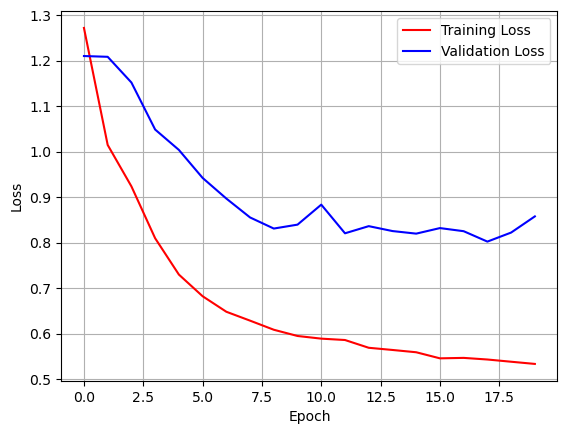

In [176]:

plt.plot(range(epoch_counter), loss_train_history, 'r-', label='Training Loss')
plt.plot(range(epoch_counter), loss_val_history, 'b-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

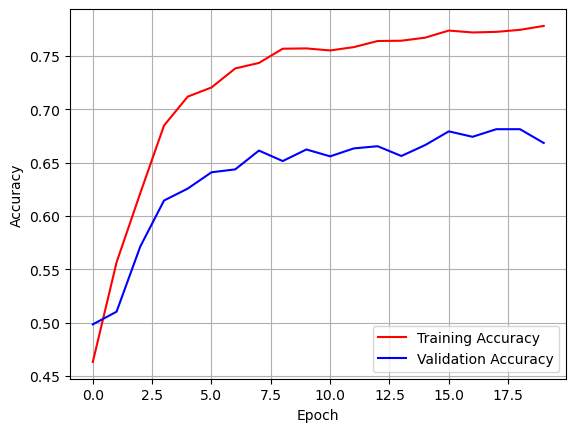

In [177]:
plt.plot(range(epoch_counter), acc_train_history, 'r-', label='Training Accuracy')
plt.plot(range(epoch_counter), acc_val_history, 'b-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()